In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random
import cv2
from tqdm import tqdm
import dgl
import networkx as nx
from torchvision.datasets import STL10
from torchvision import transforms
 
STL10_train = STL10("STL10", split='train', download=True)
 
STL10_test = STL10("STL10", split='test', download=True, transform=transforms.ToTensor())


Using backend: pytorch


Files already downloaded and verified
Files already downloaded and verified


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [14]:
#点数が最大のときと最小のときの画像・kp・desをそれぞれの手法ごとに保存
akaze=cv2.AKAZE_create()
sift=cv2.SIFT_create()
detect_dict={'akaze':{'time':0,'ave':0,'max':0,'min':0,'most':{'img':0,'kp':0,'des':0},'worst':{'img':0,'kp':0,'des':0}},
             'sift':{'time':0,'ave':0,'max':0,'min':0,'most':{'img':0,'kp':0,'des':0},'worst':{'img':0,'kp':0,'des':0}}}

In [19]:
#akaze
kps=[]
dess=[]
imgs=[]
for i,j in STL10_train:
    img = np.array(i)
    #img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img=cv2.resize(img,(512,512),interpolation=cv2.INTER_LANCZOS4)
    imgs.append(img)


In [23]:
#kpの数が0のときはスキップする
MIN=10000
MAX=-1000
start=time.time()
for i in imgs:
    kp,des=akaze.detectAndCompute(i,None)

    if len(kp)==0:
        continue
    else:
        kps.append(len(kp))
        dess.append(len(des))

    if MIN>len(kp):
        detect_dict['akaze']['worst']['img'] = i
        detect_dict['akaze']['worst']['kp'] = kp
        detect_dict['akaze']['worst']['des'] = des

        MIN=len(kp)

    if MAX<len(kp):
        detect_dict['akaze']['most']['img'] = i
        detect_dict['akaze']['most']['kp'] = kp
        detect_dict['akaze']['most']['des'] = des
        
        MAX=len(kp)

detect_dict['akaze']['time']=time.time() - start
detect_dict['akaze']['ave']=sum(kps)/len(kps)
detect_dict['akaze']['max']=max(kps)
detect_dict['akaze']['min']=min(kps)

In [8]:
print(detect_dict['akaze'])
print(detect_dict['sift'])

{'time': 80.48223042488098, 'ave': 491.8908, 'max': 2065, 'min': 1, 'most': {'img': array([[[209, 210, 200],
        [209, 210, 200],
        [209, 210, 200],
        ...,
        [164, 157, 137],
        [173, 166, 145],
        [175, 169, 147]],

       [[209, 210, 200],
        [209, 210, 200],
        [209, 210, 200],
        ...,
        [164, 157, 137],
        [173, 166, 145],
        [176, 169, 147]],

       [[209, 210, 200],
        [209, 210, 200],
        [209, 210, 200],
        ...,
        [166, 158, 138],
        [175, 167, 146],
        [177, 170, 148]],

       ...,

       [[177, 172, 153],
        [177, 172, 153],
        [178, 173, 154],
        ...,
        [227, 203, 170],
        [227, 203, 170],
        [227, 203, 170]],

       [[177, 172, 153],
        [177, 172, 153],
        [178, 173, 154],
        ...,
        [227, 202, 170],
        [226, 202, 170],
        [226, 202, 170]],

       [[177, 172, 153],
        [177, 172, 153],
        [178, 173, 154],
   

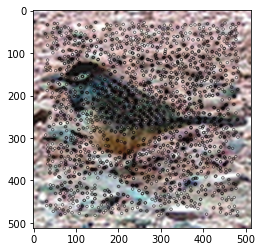

In [38]:
kpimg=cv2.drawKeypoints(detect_dict['akaze']['most']['img'],detect_dict['akaze']['most']['kp'],None,4)
plt.imshow(kpimg)
plt.savefig('images/akaze_most.jpg',dpi=300)
plt.show()

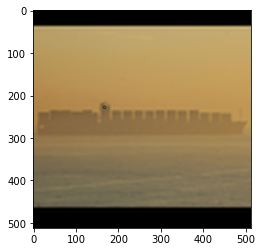

In [37]:
kpimg=cv2.drawKeypoints(detect_dict['akaze']['worst']['img'],detect_dict['akaze']['worst']['kp'],None,4)
plt.imshow(kpimg)
plt.savefig('images/akaze_worst.jpg',dpi=300)
plt.show()

In [26]:
#sift
kps=[]
dess=[]
imgs=[]
for i,j in STL10_train:
    img = np.array(i)
    #img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img=cv2.resize(img,(512,512),interpolation=cv2.INTER_LANCZOS4)
    img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    imgs.append(img)


In [27]:
#kpの数が0のときはスキップする
MIN=10000
MAX=-1000
start=time.time()
for i in imgs:
    kp,des=sift.detectAndCompute(i,None)

    if len(kp)==0:
        continue
    else:
        kps.append(len(kp))
        dess.append(len(des))

    if MIN>len(kp):
        detect_dict['sift']['worst']['img'] = i
        detect_dict['sift']['worst']['kp'] = kp
        detect_dict['sift']['worst']['des'] = des

        MIN=len(kp)

    if MAX<len(kp):
        detect_dict['sift']['most']['img'] = i
        detect_dict['sift']['most']['kp'] = kp
        detect_dict['sift']['most']['des'] = des
        
        MAX=len(kp)

detect_dict['sift']['time']=time.time() - start
detect_dict['sift']['ave']=sum(kps)/len(kps)
detect_dict['sift']['max']=max(kps)
detect_dict['sift']['min']=min(kps)

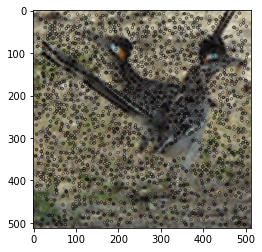

In [39]:
kpimg=cv2.drawKeypoints(detect_dict['sift']['most']['img'],detect_dict['sift']['most']['kp'],None,4)
plt.imshow(kpimg)
plt.savefig('images/sift_most.jpg',dpi=300)
plt.show()

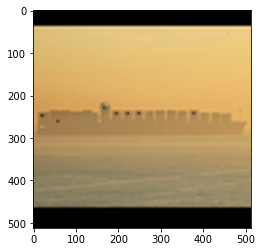

In [40]:
kpimg=cv2.drawKeypoints(detect_dict['sift']['worst']['img'],detect_dict['sift']['worst']['kp'],None,4)
plt.imshow(kpimg)
plt.savefig('images/sift_worst.jpg',dpi=300)
plt.show()

In [34]:
techs=['akaze','sift']
for tech in techs:
    print(tech)
    print(f'time:{detect_dict[tech]["time"]}\nmax:{detect_dict[tech]["max"]}\nmin:{detect_dict[tech]["min"]}\nave:{detect_dict[tech]["ave"]}\n')

akaze
time:77.02941870689392
max:2065
min:1
ave:491.8908

sift
time:130.8208065032959
max:2228
min:8
ave:472.4344

